In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
torch.__version__

'1.9.0+cu111'

### 数据准备

MINST数据集在torchvision中是现存好的，所以可以直接加载该数据集

In [3]:
# 对加载的数据做标准化，其实就是归一化，使其范围在（-1，1）之间
"""
    该图形变化首先将输入的参数变成（channels，height，widlth）维度的张量，取值范围为（0，1）
    之后用Normalize函数将输入进行归一化，平均值设为0.5，方差设为0.5，取值范围变成（-1，1）
"""
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])

In [4]:
# 加载训练集
train_ds = torchvision.datasets.MNIST('data',
                                      train = True, 
                                      transform = transform, 
                                      download = True)

D:\Tools\miniConda\envs\gan\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size = 64, shuffle = True)

In [6]:
#可以看一下一批次的shape
imgs, _ = next(iter(dataloader))
imgs.shape

torch.Size([64, 1, 28, 28])

### 定义生成器模型

生成器的输入是长度为100的 噪声（正太分布随机数）
生成器的输出是图片，图片大小为（1，28，28）的tensor

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(nn.Linear(100,256),
                                  nn.ReLU(),
                                  nn.Linear(256,512),
                                  nn.ReLU(),
                                  nn.Linear(512,28*28),
                                  nn.Tanh()
                                  )
    def forward(self,x):                    # x 表示长度100的噪声输入
        img = self.main(x)                  #reshape 成 （1，28，28）的图片
        img = img.view(-1,28,28,1)
        
        return img

### 定义判别器模型
判别器的输入是 （1，28，28）的图片， 输出为二分类的概率值（sigmoid进行激活）

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(nn.Linear(28*28,512),
                                  nn.LeakyReLU(),
                                  nn.Linear(512,256),
                                  nn.LeakyReLU(),
                                  nn.Linear(256,1),
                                  nn.Sigmoid() 
                                  )
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.main(x)
        
        return x

### 初始化模型，优化器以及损失函数

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
# 初始化模型
gen = Generator().to(device)
dis = Discriminator().to(device)

In [11]:
# 初始化优化器
d_optim = torch.optim.Adam(dis.parameters(), lr=0.0001) #判别器的优化函数初始化
g_optim = torch.optim.Adam(gen.parameters(), lr=0.0001) #生成器的优化函数初始化

In [12]:
# 损失函数初始化
loss_function = torch.nn.BCELoss()

### 绘图函数


In [13]:
def gen_img_plot(model,test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2)   #该目的是将（-1，1）转换到（0，1）的图像
        plt.axis('off')
    plt.show()

In [14]:
test_input = torch.randn(16,100, device=device)   #16个长度为100的正态分布随机数

### GAN的训练

In [15]:
D_loss = []
G_loss = [] #这两个函数用来存储损失函数

Epoch: 0


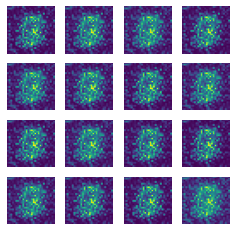

Epoch: 1


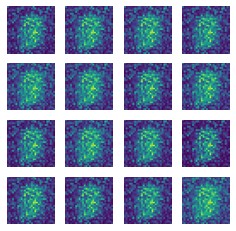

Epoch: 2


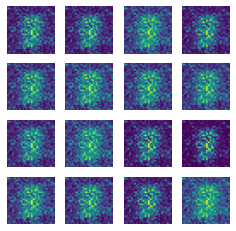

Epoch: 3


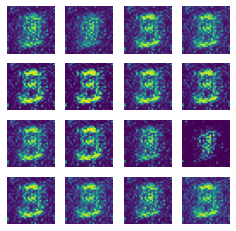

Epoch: 4


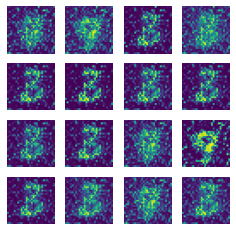

Epoch: 5


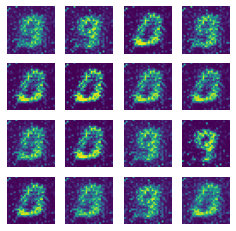

Epoch: 6


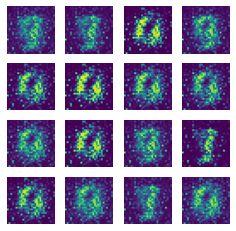

Epoch: 7


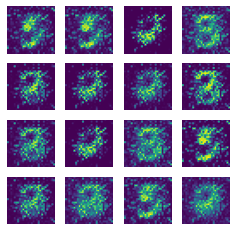

Epoch: 8


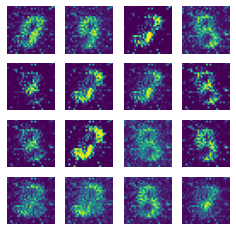

Epoch: 9


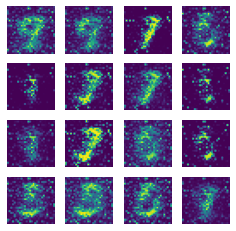

Epoch: 10


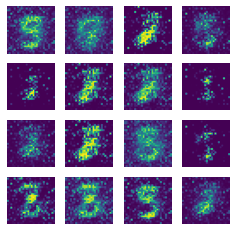

Epoch: 11


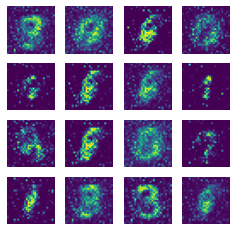

Epoch: 12


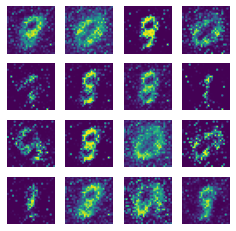

Epoch: 13


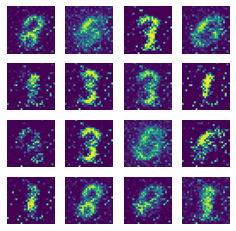

Epoch: 14


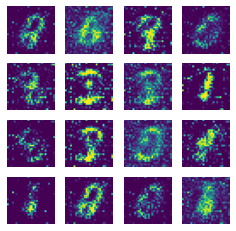

Epoch: 15


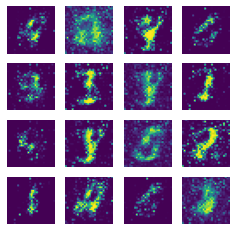

Epoch: 16


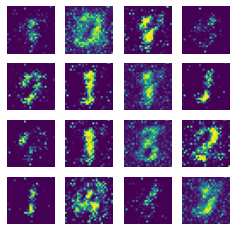

Epoch: 17


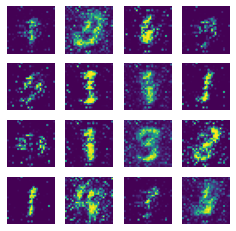

Epoch: 18


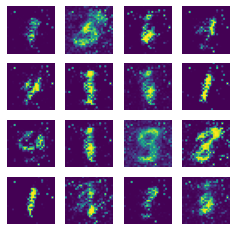

Epoch: 19


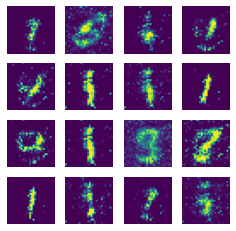

In [16]:
# 训练循环
for epoch in range(20):
    d_epoch_loss = 0 
    g_epoch_loss = 0
    count = len(dataloader)  #返回批次数 一共是938个批次 一个批次里64个样本 
    for step, (img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)  #返回img的第一维的大小，即batchsize的大小
        random_noise = torch.randn(size,100,device = device) 
        
        d_optim.zero_grad()
        
        real_output = dis(img) #对判别器输入真实的图片，得到的是对真实图片的预测结果
        d_real_loss = loss_function(real_output,
                                       torch.ones_like(real_output))

        gen_img = gen(random_noise)
        fake_output = dis(gen_img.detach()) #判别器对输入生成图片的预测
        d_fake_loss = loss_function(fake_output,
                                       torch.zeros_like(real_output))
        
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optim.step()
        
        #接下来是生成器的优化
        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_function(fake_output,
                               torch.ones_like(fake_output))
        
        g_loss.backward()
        g_optim.step()
        
    with torch.no_grad():
        d_epoch_loss += d_loss
        g_epoch_loss += g_loss
            
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:', epoch)
        gen_img_plot(gen,test_input)